In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

In [3]:
# parameters
batch_size=64
img_size=28
sensor_unit=256
lstm_size=256
N_glimpse=10
MC_test=128
loc_std=0.2
tot_size=batch_size*MC_test

In [4]:
class Glimpse_Network():
    def __init__(self):
        self.glimspe_size=[5,10,15]
        self.concat_size=5
        self.img_net=tf.layers.Dense(units=sensor_unit,name='glimpse_net/img_net')
        self.loc_net=tf.layers.Dense(units=sensor_unit,name='glimpse_net/loc_net')
        
    def glimpse_sensor(self,image,loc):
        glimpses_list=[tf.image.extract_glimpse(input=image,size=[gs,gs],offsets=loc) for gs in self.glimspe_size]
        glimpses_norm=[tf.image.resize_bilinear(g,[self.concat_size,self.concat_size]) for g in glimpses_list]
        glimpses=tf.concat(values=glimpses_norm,axis=3)  # batch_size*concat_size*concat_size*3
        return glimpses
    
    def forward(self,image,loc):
        glimpses=self.glimpse_sensor(image,loc) # tot_size*concat_size*concat_size*3
        glimpses=tf.stop_gradient(glimpses)  # gradient has no need to flow through glimpses
        g_image=tf.nn.relu(self.img_net(inputs=tf.layers.flatten(glimpses)))
        g_loc=tf.nn.relu(self.loc_net(inputs=loc))
        g_out=tf.nn.relu(g_image+g_loc)
        return g_out

In [5]:
tf.reset_default_graph()
X=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1])
y=tf.placeholder(dtype=tf.int64,shape=[None,10])
this_size=tf.shape(X)[0]
start_location=tf.random_uniform(shape=[this_size,2],minval=-1.0,maxval=1.0)
gNet=Glimpse_Network()

lstm_cell = tf.contrib.rnn.LSTMCell(lstm_size)
state = lstm_cell.zero_state(this_size, tf.float32)

emission_net=tf.layers.Dense(units=2,name='emission_net')
baseline_net=tf.layers.Dense(units=1,name='baseline_net')
predict_net=tf.layers.Dense(units=10,name='predict_net')

def loglikelihood(sample,mean):
    gaussian=tf.distributions.Normal(loc=mean,scale=tf.constant([loc_std,loc_std]))
    llh=-gaussian.log_prob(sample)
    return tf.reduce_sum(llh,axis=1)
    
loc_his=[]
loglikelihood_his=[]
baseline_his=[]
normalized_loc=start_location
for ng in range(N_glimpse):
    loc_his.append(normalized_loc)
    
    # extract glimpse
    glimpses_out=gNet.forward(X,normalized_loc)
    
    # RNN
    lstm_output,state=lstm_cell(glimpses_out,state)
    
    # emit mean of location
    loc_mean=emission_net(inputs=lstm_output)
    
    # sample next location by gaussian distribution centered at loc_mean
    loc_sample=tf.random_normal(shape=(this_size,2),mean=loc_mean,stddev=loc_std)
    loc_sample=tf.stop_gradient(loc_sample)
    
    # calculate the -loglikelihood of the sampled position
    llh=loglikelihood(loc_sample,loc_mean)
    loglikelihood_his.append(llh)
    
    # normalize the location for next input
    normalized_loc=tf.tanh(loc_sample)
    normalized_loc=tf.stop_gradient(normalized_loc)
    
    # output time independent baseline
    # stop gradient on lstm output (************? require proof************)
    baseline=baseline_net(inputs=tf.stop_gradient(lstm_output))
    baseline_his.append(tf.squeeze(baseline))

# pack data for calculation
baseline_his=tf.stack(baseline_his)
loglikelihood_his=tf.stack(loglikelihood_his)

# make prediction
score=predict_net(inputs=lstm_output)
prediction=tf.argmax(score,1)

# calculate reward, do variance reduction and calculate reinforced loglikelihood
reward=tf.cast(tf.equal(prediction,tf.argmax(y,1)),dtype=tf.float32)
# stop gradient on reward (************? require proof************)
reward=tf.stop_gradient(reward)
accuracy=tf.reduce_sum(reward)/tf.cast(this_size,dtype=tf.float32)
reduce_var_reward=reward-tf.stop_gradient(baseline_his)
reinforce_llh=tf.reduce_mean(loglikelihood_his*reduce_var_reward)

# regression baseline towards reward
baseline_mse=tf.reduce_mean(tf.square(reward-baseline_his))

# softmax to output
softmax_loss=tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score))

# summarize loss
loss=reinforce_llh+baseline_mse+softmax_loss


optimizier=tf.train.RMSPropOptimizer(learning_rate=1e-4)
train_step = optimizier.minimize(loss)

In [6]:
max_epoch=50
print_every=50

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        # prepare data for monte carlo test
        images=np.tile(images,(MC_test,1))
        labels=np.tile(labels,(MC_test,1))
        feed_dict={X:images.reshape(tot_size,28,28,1),y:labels}
        l1,l2,l3,loss_num,acc_num,_ = sess.run([reinforce_llh,baseline_mse,softmax_loss,loss,accuracy,train_step],feed_dict=feed_dict)
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'loss=%8f, accuracy=%.3f%%' % (loss_num,acc_num*100.0),l1,l2,l3)

def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        # no Monte Carlo test during evaludation step
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images.reshape(batch_size,28,28,1),y:labels})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy

In [7]:
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]

saver = tf.train.Saver()

with tf.Session() as sess:
#     print(tf.global_variables())
    tf.global_variables_initializer().run()
    max_acc=None
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'start epoch %d/%d' % (epoch+1,max_epoch))
        train()
        loss_train,acc_train=eval(mnist.train,500)
        loss_val,acc_val=eval(mnist.validation,70)
        loss_test,acc_test=eval(mnist.test,150)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        
        if max_acc==None or acc_val>max_acc:
            max_acc=acc_val
            save_path = saver.save(sess, "model/RAM/RAM.ckpt")
            print("Currently maximum accuracy on validation set, model saved in path: %s" % save_path)
        
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))

2018-04-17 15:05:05 start epoch 1/50
2018-04-17 15:05:06 iteration 1/859: loss=2.340601, accuracy=7.764% -0.0660799 0.10659226 2.3000884
2018-04-17 15:05:23 iteration 50/859: loss=2.371061, accuracy=6.567% -0.0579383 0.08750048 2.3414984
2018-04-17 15:05:41 iteration 100/859: loss=2.351091, accuracy=8.826% -0.04838727 0.099885 2.2995932
2018-04-17 15:05:58 iteration 150/859: loss=2.393584, accuracy=35.889% -0.13810106 0.3339675 2.197718
2018-04-17 15:06:15 iteration 200/859: loss=2.194683, accuracy=41.321% -0.11717065 0.31690976 1.9949437
2018-04-17 15:06:32 iteration 250/859: loss=1.867576, accuracy=44.202% -0.07630874 0.3228636 1.6210215
2018-04-17 15:06:49 iteration 300/859: loss=1.741830, accuracy=47.742% -0.053873636 0.31629616 1.4794073
2018-04-17 15:07:07 iteration 350/859: loss=1.475344, accuracy=60.913% -0.06830828 0.30933028 1.2343221
2018-04-17 15:07:24 iteration 400/859: loss=1.289526, accuracy=65.466% -0.07854841 0.29451975 1.0735544
2018-04-17 15:07:41 iteration 450/859: 

2018-04-17 15:25:17 iteration 800/859: loss=0.505682, accuracy=87.952% -0.027253022 0.12966695 0.40326774
2018-04-17 15:25:35 iteration 850/859: loss=0.472082, accuracy=88.245% -0.018628458 0.13155381 0.3591565
2018-04-17 15:25:38 iteration 859/859: loss=0.546305, accuracy=85.645% -0.007301538 0.14814614 0.40546077
Currently maximum accuracy on validation set, model saved in path: model/RAM/RAM.ckpt
2018-04-17 15:25:48 end epoch 4/50: acc_train=88.781% acc_val=89.464% acc_test=89.167%
2018-04-17 15:25:48 start epoch 5/50
2018-04-17 15:25:49 iteration 1/859: loss=0.540579, accuracy=86.548% -0.016203891 0.13807347 0.41870943
2018-04-17 15:26:06 iteration 50/859: loss=0.400855, accuracy=89.697% -0.020073716 0.114096306 0.3068328
2018-04-17 15:26:24 iteration 100/859: loss=0.354162, accuracy=91.040% -0.04145334 0.10858004 0.287035
2018-04-17 15:26:41 iteration 150/859: loss=0.514729, accuracy=86.804% -0.017538672 0.13140342 0.40086478
2018-04-17 15:26:59 iteration 200/859: loss=0.493016, a

2018-04-17 15:44:42 iteration 550/859: loss=0.291814, accuracy=92.004% -0.0126995 0.08283742 0.22167647
2018-04-17 15:45:00 iteration 600/859: loss=0.301310, accuracy=92.200% -0.016412694 0.08081417 0.23690878
2018-04-17 15:45:18 iteration 650/859: loss=0.501947, accuracy=87.109% 0.013990265 0.12080003 0.36715657
2018-04-17 15:45:36 iteration 700/859: loss=0.173380, accuracy=95.752% -0.016821077 0.05132284 0.13887802
2018-04-17 15:45:53 iteration 750/859: loss=0.138957, accuracy=96.509% -0.021134503 0.045409434 0.11468211
2018-04-17 15:46:12 iteration 800/859: loss=0.142729, accuracy=96.436% -0.02591003 0.045240976 0.123398244
2018-04-17 15:46:30 iteration 850/859: loss=0.440164, accuracy=89.111% -0.00037973718 0.1015597 0.33898377
2018-04-17 15:46:33 iteration 859/859: loss=0.162460, accuracy=95.911% -0.02332904 0.050132215 0.13565637
Currently maximum accuracy on validation set, model saved in path: model/RAM/RAM.ckpt
2018-04-17 15:46:44 end epoch 8/50: acc_train=92.772% acc_val=93.0

2018-04-17 16:04:26 iteration 300/859: loss=0.092633, accuracy=97.595% -0.019584548 0.029074436 0.08314271
2018-04-17 16:04:44 iteration 350/859: loss=0.129500, accuracy=96.741% -0.013135159 0.03609615 0.10653862
2018-04-17 16:05:02 iteration 400/859: loss=0.278365, accuracy=92.212% -0.0013980841 0.07384599 0.20591679
2018-04-17 16:05:20 iteration 450/859: loss=0.078579, accuracy=98.181% -0.023847105 0.025153602 0.07727218
2018-04-17 16:05:38 iteration 500/859: loss=0.368782, accuracy=91.956% 0.0073391674 0.07578392 0.2856586
2018-04-17 16:05:57 iteration 550/859: loss=0.383883, accuracy=91.846% -0.00014324347 0.07744484 0.3065818
2018-04-17 16:06:14 iteration 600/859: loss=0.163587, accuracy=95.947% -0.0064475113 0.042127334 0.12790756
2018-04-17 16:06:32 iteration 650/859: loss=0.179185, accuracy=95.911% -0.0074442485 0.042187233 0.14444175
2018-04-17 16:06:51 iteration 700/859: loss=0.169182, accuracy=95.752% -0.013151211 0.043789208 0.13854384
2018-04-17 16:07:09 iteration 750/859:

2018-04-17 16:24:01 iteration 1/859: loss=0.185699, accuracy=95.190% -0.003582172 0.047905933 0.14137505
2018-04-17 16:24:19 iteration 50/859: loss=0.176229, accuracy=95.227% -0.0048415964 0.04665704 0.13441336
2018-04-17 16:24:36 iteration 100/859: loss=0.115315, accuracy=96.997% -0.012667211 0.03129887 0.096683234
2018-04-17 16:24:55 iteration 150/859: loss=0.161541, accuracy=95.642% -0.007199387 0.043027423 0.12571329
2018-04-17 16:25:12 iteration 200/859: loss=0.108467, accuracy=97.241% -0.010634301 0.029257065 0.08984411
2018-04-17 16:25:32 iteration 250/859: loss=0.195742, accuracy=94.885% -0.0013254129 0.049733724 0.14733417
2018-04-17 16:25:50 iteration 300/859: loss=0.101793, accuracy=97.266% -0.010646713 0.029910177 0.08253002
2018-04-17 16:26:07 iteration 350/859: loss=0.171293, accuracy=96.594% -0.0061693033 0.03452704 0.14293545
2018-04-17 16:26:25 iteration 400/859: loss=0.243409, accuracy=94.360% 0.00022350908 0.053040214 0.19014502
2018-04-17 16:26:43 iteration 450/859:

2018-04-17 16:45:09 iteration 850/859: loss=0.138582, accuracy=96.289% -0.007369435 0.03655238 0.10939917
2018-04-17 16:45:12 iteration 859/859: loss=0.049313, accuracy=98.633% -0.014891909 0.015817706 0.048386738
2018-04-17 16:45:23 end epoch 19/50: acc_train=95.822% acc_val=96.228% acc_test=95.958%
2018-04-17 16:45:23 start epoch 20/50
2018-04-17 16:45:24 iteration 1/859: loss=0.136229, accuracy=96.167% -0.006624622 0.037628002 0.10522591
2018-04-17 16:45:41 iteration 50/859: loss=0.076211, accuracy=98.022% -0.009404884 0.021574771 0.064041115
2018-04-17 16:45:59 iteration 100/859: loss=0.237023, accuracy=94.629% 0.00039781444 0.05054579 0.18607894
2018-04-17 16:46:17 iteration 150/859: loss=0.197008, accuracy=95.093% -5.0116865e-05 0.04732661 0.14973152
2018-04-17 16:46:35 iteration 200/859: loss=0.355820, accuracy=91.113% 0.016436605 0.083143376 0.25623986
2018-04-17 16:46:53 iteration 250/859: loss=0.049554, accuracy=98.657% -0.014485866 0.015878687 0.048161484
2018-04-17 16:47:11

2018-04-17 17:04:45 iteration 550/859: loss=0.069532, accuracy=98.120% -0.010681436 0.019709494 0.06050405
2018-04-17 17:05:04 iteration 600/859: loss=0.055640, accuracy=98.718% -0.01241338 0.014255084 0.053797834
2018-04-17 17:05:22 iteration 650/859: loss=0.160164, accuracy=96.289% -0.0005340746 0.03567175 0.12502675
2018-04-17 17:05:39 iteration 700/859: loss=0.136731, accuracy=97.217% -0.002503772 0.027488953 0.11174627
2018-04-17 17:05:57 iteration 750/859: loss=0.183000, accuracy=95.593% -7.066897e-05 0.043484844 0.13958587
2018-04-17 17:06:15 iteration 800/859: loss=0.040273, accuracy=98.792% -0.0085507855 0.012934771 0.03588903
2018-04-17 17:06:33 iteration 850/859: loss=0.147531, accuracy=96.460% -0.0007532185 0.03409337 0.11419082
2018-04-17 17:06:36 iteration 859/859: loss=0.208838, accuracy=95.227% 0.004682095 0.045611195 0.15854435
2018-04-17 17:06:47 end epoch 23/50: acc_train=96.834% acc_val=97.188% acc_test=97.229%
2018-04-17 17:06:47 start epoch 24/50
2018-04-17 17:06:

2018-04-17 17:25:08 iteration 350/859: loss=0.038810, accuracy=98.816% -0.0059594894 0.012427645 0.032341585
2018-04-17 17:25:26 iteration 400/859: loss=0.122498, accuracy=97.131% -0.0020866871 0.027480325 0.09710396
2018-04-17 17:25:45 iteration 450/859: loss=0.033271, accuracy=99.023% -0.009494679 0.010623482 0.032141965
2018-04-17 17:26:03 iteration 500/859: loss=0.030834, accuracy=99.207% -0.009090029 0.009052093 0.030871874
2018-04-17 17:26:21 iteration 550/859: loss=0.171544, accuracy=95.325% 0.0024973415 0.044605874 0.124440834
2018-04-17 17:26:39 iteration 600/859: loss=0.095786, accuracy=97.607% -0.00418483 0.02348258 0.076488234
2018-04-17 17:26:57 iteration 650/859: loss=0.091756, accuracy=97.546% -0.004285938 0.024322195 0.071719944
2018-04-17 17:27:16 iteration 700/859: loss=0.067074, accuracy=98.267% -0.0057019503 0.017552402 0.055223923
2018-04-17 17:27:34 iteration 750/859: loss=0.177632, accuracy=96.228% 0.0010603548 0.03619931 0.14037208
2018-04-17 17:27:53 iteration 

2018-04-17 17:45:33 iteration 150/859: loss=0.136088, accuracy=97.229% 0.001802243 0.026898265 0.10738721
2018-04-17 17:45:51 iteration 200/859: loss=0.068976, accuracy=98.108% -0.003868966 0.018197099 0.05464827
2018-04-17 17:46:08 iteration 250/859: loss=0.059987, accuracy=98.315% -0.0042247823 0.016714785 0.047497097
2018-04-17 17:46:27 iteration 300/859: loss=0.058182, accuracy=98.438% -0.0076171756 0.016015308 0.049783967
2018-04-17 17:46:45 iteration 350/859: loss=0.082626, accuracy=97.815% -0.0028093085 0.021457763 0.06397714
2018-04-17 17:47:04 iteration 400/859: loss=0.194528, accuracy=97.009% -0.0007502711 0.02983357 0.16544506
2018-04-17 17:47:22 iteration 450/859: loss=0.061464, accuracy=98.242% -0.004082558 0.01748038 0.0480662
2018-04-17 17:47:42 iteration 500/859: loss=0.139463, accuracy=96.802% 0.0007971901 0.030937454 0.1077282
2018-04-17 17:48:00 iteration 550/859: loss=0.088171, accuracy=97.839% -0.0021482662 0.021378856 0.068940714
2018-04-17 17:48:18 iteration 600/

2018-04-17 18:06:20 end epoch 34/50: acc_train=97.853% acc_val=97.500% acc_test=97.844%
2018-04-17 18:06:20 start epoch 35/50
2018-04-17 18:06:20 iteration 1/859: loss=0.116842, accuracy=97.668% -0.0008278385 0.022319663 0.09534985
2018-04-17 18:06:38 iteration 50/859: loss=0.113368, accuracy=97.070% 0.0005633718 0.028272295 0.08453277
2018-04-17 18:06:56 iteration 100/859: loss=0.193887, accuracy=95.581% 0.009434494 0.04176092 0.14269137
2018-04-17 18:07:15 iteration 150/859: loss=0.181990, accuracy=95.642% 0.004929104 0.04102394 0.13603738
2018-04-17 18:07:33 iteration 200/859: loss=0.069895, accuracy=98.096% -0.0028457567 0.018432943 0.054307394
2018-04-17 18:07:52 iteration 250/859: loss=0.038545, accuracy=99.084% -0.005333265 0.0094925 0.03438562
2018-04-17 18:08:10 iteration 300/859: loss=0.157671, accuracy=95.984% 0.0049909577 0.03818698 0.11449304
2018-04-17 18:08:28 iteration 350/859: loss=0.075519, accuracy=97.913% -0.00015249258 0.020270472 0.055400535
2018-04-17 18:08:46 it

2018-04-17 18:26:38 iteration 650/859: loss=0.040136, accuracy=99.097% -0.0042264224 0.009474603 0.03488793
2018-04-17 18:26:56 iteration 700/859: loss=0.027951, accuracy=99.377% -0.0071415007 0.006649027 0.028443363
2018-04-17 18:27:15 iteration 750/859: loss=0.068174, accuracy=98.169% -0.0017162736 0.017879684 0.052010253
2018-04-17 18:27:33 iteration 800/859: loss=0.165260, accuracy=95.715% 0.0067072934 0.04086591 0.1176866
2018-04-17 18:27:51 iteration 850/859: loss=0.033708, accuracy=99.109% -0.0062521347 0.009119974 0.03084046
2018-04-17 18:27:54 iteration 859/859: loss=0.030278, accuracy=99.341% -0.008481493 0.007411778 0.03134814
2018-04-17 18:28:05 end epoch 38/50: acc_train=97.913% acc_val=97.924% acc_test=97.802%
2018-04-17 18:28:05 start epoch 39/50
2018-04-17 18:28:05 iteration 1/859: loss=0.015153, accuracy=99.573% -0.007374841 0.004872028 0.01765602
2018-04-17 18:28:23 iteration 50/859: loss=0.121534, accuracy=97.949% -0.0006394277 0.020433305 0.10174049
2018-04-17 18:28

2018-04-17 18:47:04 iteration 450/859: loss=0.051471, accuracy=98.682% -0.0055657574 0.013199928 0.043837253
2018-04-17 18:47:22 iteration 500/859: loss=0.098205, accuracy=97.388% 0.0005796623 0.024826536 0.07279885
2018-04-17 18:47:41 iteration 550/859: loss=0.016223, accuracy=99.561% -0.006390025 0.004792548 0.017820043
2018-04-17 18:47:59 iteration 600/859: loss=0.035442, accuracy=99.109% -0.0052144886 0.009104947 0.031551704
2018-04-17 18:48:17 iteration 650/859: loss=0.132077, accuracy=96.326% 0.0043703415 0.03510364 0.092602864
2018-04-17 18:48:35 iteration 700/859: loss=0.098174, accuracy=97.278% 0.0029200993 0.026288068 0.06896628
2018-04-17 18:48:54 iteration 750/859: loss=0.074032, accuracy=97.974% -0.001051511 0.01922197 0.055861674
2018-04-17 18:49:12 iteration 800/859: loss=0.044305, accuracy=98.865% -0.0048658326 0.011248166 0.037922964
2018-04-17 18:49:30 iteration 850/859: loss=0.078342, accuracy=97.913% -0.0012072844 0.02048263 0.059066325
2018-04-17 18:49:33 iteration

2018-04-17 19:07:20 iteration 200/859: loss=0.063862, accuracy=98.291% -0.0021998163 0.016769964 0.049292244
2018-04-17 19:07:38 iteration 250/859: loss=0.150656, accuracy=96.472% 0.005088339 0.03357551 0.11199214
2018-04-17 19:07:56 iteration 300/859: loss=0.022119, accuracy=99.365% -0.0026848598 0.006426192 0.018377531
2018-04-17 19:08:15 iteration 350/859: loss=0.025684, accuracy=99.280% -0.0045591705 0.007174374 0.023068676
2018-04-17 19:08:33 iteration 400/859: loss=0.081141, accuracy=97.888% -6.155996e-06 0.020478653 0.060668007
2018-04-17 19:08:51 iteration 450/859: loss=0.079722, accuracy=97.717% 0.0007062127 0.022248188 0.056767363
2018-04-17 19:09:09 iteration 500/859: loss=0.102876, accuracy=97.803% -0.00078705215 0.021464394 0.08219904
2018-04-17 19:09:28 iteration 550/859: loss=0.056408, accuracy=98.535% -0.0038389072 0.014435617 0.04581098
2018-04-17 19:09:46 iteration 600/859: loss=0.137066, accuracy=96.533% 0.006566502 0.033209763 0.097290196
2018-04-17 19:10:04 iterati

Currently maximum accuracy on validation set, model saved in path: model/RAM/RAM.ckpt
2018-04-17 19:27:56 end epoch 49/50: acc_train=98.356% acc_val=98.371% acc_test=98.219%
2018-04-17 19:27:56 start epoch 50/50
2018-04-17 19:27:56 iteration 1/859: loss=0.061641, accuracy=98.291% -0.0010041995 0.016382977 0.0462623
2018-04-17 19:28:14 iteration 50/859: loss=0.026769, accuracy=99.329% -0.004373179 0.0068955496 0.024246445
2018-04-17 19:28:33 iteration 100/859: loss=0.189541, accuracy=95.898% 0.00923934 0.039353956 0.1409479
2018-04-17 19:28:51 iteration 150/859: loss=0.140295, accuracy=96.423% 0.0063244463 0.03468219 0.09928829
2018-04-17 19:29:09 iteration 200/859: loss=0.021219, accuracy=99.438% -0.0044347383 0.00585267 0.019801373
2018-04-17 19:29:27 iteration 250/859: loss=0.101203, accuracy=97.217% 0.003770433 0.026413357 0.0710192
2018-04-17 19:29:46 iteration 300/859: loss=0.020935, accuracy=99.451% -0.004236947 0.0056339214 0.019538473
2018-04-17 19:30:04 iteration 350/859: loss

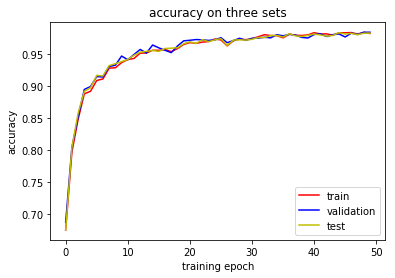

In [8]:
plt.figure(2)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()

In [9]:
saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "model/RAM/RAM.ckpt")
    _,acc_train=eval(mnist.train,num_train//batch_size)
    _,acc_val=eval(mnist.validation,num_val//batch_size)
    _,acc_test=eval(mnist.test,num_test//batch_size)
    print('Accuracy on training set is %.3f%%' % (acc_train*100.0))
    print('Accuracy on validation set is %.3f%%' % (acc_val*100.0))
    print('Accuracy on testing set is %.3f%%' % (acc_test*100.0))

INFO:tensorflow:Restoring parameters from model/RAM/RAM.ckpt
Accuracy on training set is 98.474%
Accuracy on validation set is 98.017%
Accuracy on testing set is 98.107%


In [10]:
# mean=tf.zeros((100,2),dtype=tf.float32)
# std=tf.constant([1,1],dtype=tf.float32)
# gaussian=tf.distributions.Normal(loc=mean,scale=std)
# rand=tf.random_normal(shape=(100,2),mean=0,stddev=1)
# sampled=mean+rand
# prob=-gaussian.log_prob(sampled)
# prob=tf.reduce_mean(tf.reduce_sum(prob,1))
# with tf.Session() as sess:
#     out=sess.run([prob])
#     print(out)